# **Default Setting**

* Python: 3.6.9
* ML Framework: tf-nightly-gpu 2.5.0-dev20201208
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: linux 20.04 LTS

Install below APIs using anaconda as belows.

```
conda create -n py36 python=3.6.9
conda acitvate py36
conda install jupyterlab
pip3 install tensorflow-gpu=2.4.0
pip3 install tensorflow-addons
conda install pandas, matplotlib
```

And now, you can run jupyter lab (or jupyter notebook).

```
jupyter lab
```

In [1]:
%env NOTEBOOKNAME try37
%env LOCAL_DATA_PATH data
%env CHECKPOINT_PATH ckpt
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try37
env: LOCAL_DATA_PATH=data
env: CHECKPOINT_PATH=ckpt
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import glob
import os
import platform

import numpy as np
import pandas as pd

from collections import OrderedDict
from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.4.0
tfa.__version__: 0.11.2


/home/myunggyo/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#     # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [4]:
!python -V

Python 3.6.9 :: Anaconda, Inc.


In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Wed Dec 23 14:09:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0  On |                  N/A |
|  0%   33C    P8    19W / 220W |    340MiB /  7979MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       2.2Gi        27Gi       196Mi       2.1Gi        28Gi
Swap:         2.0Gi          0B       2.0Gi


In [9]:
# platform.platform()

In [10]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# **Define Arguments**

In [11]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "TARGET_EPOCH": 500, # TARGET_MODEL EPOCH
    "EPOCH": 10, # AR_LSTM EPOCH
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    
    # Dataset Pipeline
    "WINDOW_INP": 7 * 24 * 2, # 336, 7 days
    "WINDOW_TAR": 2 * 24 * 2, # 96, 2 days
    "WINDOW_SHIFT": 1 * 24 * 2, # 1 day
    "WINDOW_STRIDE": 1,
    "WINDOW_DR": True, # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 64, # lstm units
    "NUM_FEATURES": 7, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
    
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('TARGET_EPOCH', 500),
             ('EPOCH', 10),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('WINDOW_INP', 336),
             ('WINDOW_TAR', 96),
             ('WINDOW_SHIFT', 48),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 64),
             ('NUM_FEATURES', 7),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Define Preprocessing Funciton**

In [12]:
def preprocessing(df, is_training = True, day = 24 * 2): # 24 / 0.5 [h]
    # Drop timestampes.
    try:
        # We cannot use day features, thus there is no day-position in test dataset.
        df = df.drop(["Day"], axis = 1) 
    except:
        pass
    
    
    # Timestamp to sin/cos.
    df["Time"] = 2 * df["Hour"].map(int) + (df["Minute"].map(int) // 30)
    
    day_sin = np.sin(df["Time"] * (2 * np.pi / day))
    day_cos = np.cos(df["Time"] * (2 * np.pi / day))
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    df = df.drop(["Hour", "Minute", "Time"], axis = 1)
    
    
    # Standarize.
    for column in df.columns:
        df[column] = df[column].astype(np.float32)
        if is_training:
            args[f"{column}_MEAN"] = df[column].mean()
            args[f"{column}_STD"] = df[column].std()
        
        df[column] = (df[column] - args[f"{column}_MEAN"]) / args[f"{column}_STD"]
        
    return df

## **Train & Validation Dataframes**

In [13]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))
df.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [14]:
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]

tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

tr_df.shape, vl_df.shape

((42048, 8), (10512, 8))

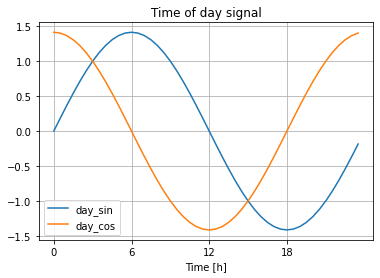

In [15]:
plt.plot(np.array(tr_df["DAY_SIN"])[:48], label = "day_sin")
plt.plot(np.array(tr_df["DAY_COS"])[:48], label = "day_cos")
plt.legend()
plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
plt.xlabel('Time [h]')
plt.grid(True)
plt.title('Time of day signal')
plt.show()

## **Test Dataframe**

In [16]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

ts_df.shape

(27216, 8)

# **Define Loss Function**

Dacon defines the loss as shown below.

$$ L_\tau = maximum(\zeta\tau, \zeta(\tau-1)) $$

However, [the pinball loss of tensorflow-addons](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/pinball_loss) is implemented as follows.

$$ L_\tau = \begin{cases} \zeta\tau & \text{ if } \zeta \geq 0 \\ -\zeta(1-\tau)=\zeta(\tau-1) & \text{ if } \zeta < 0 \end{cases}$$

The description of the symbols used in is as follows.

* $\zeta$ : y_true - y_pred
* $\tau$ : Quantile values in \[0.1, 0.2, ..., 0.9\]
* $L_\tau$ : Pinball loss function with $\tau$

The two formulas seem intuitively different, but if you actually divide the interval, you can see that they are the same. However, in experience, it seems to force an underforecast when the evaluation expression of dacon is $\tau=0.1, 0.2$. In fact, for $\tau=0.1, 0.2$, the prediction (blue lines) in the target models mostly overlaps the label (yellow lines) or lies below the graph.

In [17]:
# Define customized pinball loss function, named tuned_pinball_loss thus there exists finely differences 
# between the function of tensorflow-addons and the requirements of DACON.

# Ref: https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/losses/quantiles.py

@tf.function
def custom_pinball_loss(
    y_true: tf.Tensor, 
    y_pred: tf.Tensor, 
    tau: float = 0.5,
) -> tf.Tensor:
    """Computes the pinball loss between "y_true" and "y_pred" like dacon-style."""
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    tau = tf.cast(tau, y_pred.dtype)
    
    delta_y = tf.math.abs(y_true - y_pred)
    # It performs "tau = tau if y_true >= y_pred else (1 - tau)" for elemental-wise.
    _tau = tf.where(tf.math.greater_equal(y_true, y_pred), tau, 1 - tau)
    
    pinball = delta_y * _tau
    return tf.reduce_mean(pinball, axis = -1)


class CustomPinballLoss(tfa.utils.keras_utils.LossFunctionWrapper):
    def __init__(
        self,
        tau: tfa.utils.types.FloatTensorLike = 0.5,
        reduction: str = tf.keras.losses.Reduction.AUTO,
        name: str = "custom_pinball_loss",
    ):
        super().__init__(custom_pinball_loss, reduction = reduction, name = name, tau = tau)

# **Define Compile and Fit Function**

In [18]:
def get_callbacks(model_name):
    """Get checkpoint and tensorboard callbacks."""
    # Checkpoint callback.
    ckpt_path = os.path.join(
        os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], model_name, "cp-{epoch:03d}-{val_loss:.4f}.ckpt")
    ckpt_dir = os.path.dirname(ckpt_path)
    os.makedirs(ckpt_dir, exist_ok = True)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, verbose = 0, monitor = "val_loss", save_weights_only = True, save_best_only = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], datetime.datetime.now().strftime(f"{model_name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
    
    return [cp_callback, tb_callback]
    

def compile_and_fit(model, tau, tr_dataset, vl_dataset, epochs, verbose = 0, loss_weights = None):
    model.compile(
        loss = CustomPinballLoss(tau = tau),
        loss_weights = loss_weights,
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    print(f"Model {model.name}...")

    history = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = epochs,
        verbose = verbose,
        callbacks = get_callbacks(model.name))

    return history

# **Phase \#1: Target Predict Model**

## **Make Dataset Pipelines**

In [19]:
@tf.function
def _split_window(features):
    """inp: [batch, 7], tar: [batch, 1]"""
    return tf.split(features, [-1, 1], axis = 0)

In [20]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).shuffle(100_000
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
#                     ).shuffle(100_000
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
#                     ).shuffle(100_000
                    ).batch(args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
ts_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


### **Take Samples**

In [56]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [57]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [58]:
for element in ts_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


## **Create Network**

```
"""Pytorch Style"""
class TARGET_MODEL(tf.keras.Model):
    def __init__(self, model_name, units = 64):
        super(TARGET_MODEL, self).__init__(name = model_name)
        self.units = units
        
        self.dense1 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense2 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense3 = tf.keras.layers.Dense(units = 1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x            
```

In [21]:
def TARGET_MODEL(model_name, units = 64):
    model_input = tf.keras.layers.Input(shape = [args["NUM_FEATURES"], ], dtype = tf.float32)
    
    x = tf.keras.layers.Dense(units = units, activation = "relu")(model_input)
    x = tf.keras.layers.Dense(units = units, activation = "relu")(x)    
    model_output = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [22]:
tmp = TARGET_MODEL("tmp")
tmp.summary()

Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [30]:
# tf.keras.utils.plot_model(tmp)

In [31]:
del tmp

## **Compile and Fit**

In [23]:
%%time
for tau in np.arange(0.1, 1, 0.1):
    model = TARGET_MODEL(f"T{tau:.1f}")
    _ = compile_and_fit(model, tau, tr_dataset, vl_dataset, args["TARGET_EPOCH"])

Model T0.1...
Model T0.2...
Model T0.3...
Model T0.4...
Model T0.5...
Model T0.6...
Model T0.7...
Model T0.8...
Model T0.9...
CPU times: user 49min 18s, sys: 3min 21s, total: 52min 39s
Wall time: 33min 41s


## **Predict**

In [24]:
def load_latest_specific_models(ckpt_folders: list, create_model_fn) -> list:
    """Return latest models for a specific function s.t. makes a model."""
    models = []
    print()
    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        model = create_model_fn(model_name = latest.split(os.path.sep)[2])
        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models

In [27]:
target_models = load_latest_specific_models(
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "T*"))),
    create_model_fn = TARGET_MODEL)

# Sample evaluation.
target_models[0].compile(
    loss = tfa.losses.PinballLoss(tau = 0.1),
    optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
target_models[0].evaluate(ts_dataset, verbose = 1)


Load latest checkpoints: ckpt/try37/T0.1/cp-434-0.0033.ckpt...
Load latest checkpoints: ckpt/try37/T0.2/cp-429-0.0045.ckpt...
Load latest checkpoints: ckpt/try37/T0.3/cp-420-0.0057.ckpt...
Load latest checkpoints: ckpt/try37/T0.4/cp-303-0.0064.ckpt...
Load latest checkpoints: ckpt/try37/T0.5/cp-258-0.0064.ckpt...
Load latest checkpoints: ckpt/try37/T0.6/cp-429-0.0065.ckpt...
Load latest checkpoints: ckpt/try37/T0.7/cp-359-0.0060.ckpt...
Load latest checkpoints: ckpt/try37/T0.8/cp-303-0.0049.ckpt...
Load latest checkpoints: ckpt/try37/T0.9/cp-469-0.0030.ckpt...
213/213 [==============================] - 0s 785us/step - loss: 0.0044


0.004583335015922785

## **Visualize**

Visualize between label and predictions.

In [40]:
def draw_history(history, title):
    
    plt.figure(figsize = (14, 4), facecolor = "white", dpi = 80)
    
    plt.plot(history.epoch, history.history["loss"], label = "loss")
    plt.plot(history.epoch, history.history["val_loss"], label = "val_loss")
    
    plt.legend()
    plt.title(title, fontsize = "x-large")
    plt.xlabel("Epoch")
    plt.ylabel("Pinball Loss")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [42]:
# for tau, history in zip(np.arange(0.1, 1, 0.1), histories):
#     draw_history(history, title = f"Target Model T{tau:.1f}")

In [44]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

In [28]:
def draw_pred(y_pred, y_true, model_name, save_fig = True):
    """Draw the predictions and labels."""
    plt.figure(figsize = (14, 4), facecolor = "white")
    plt.plot(y_pred, lw = 1.5, label = "Predictions")
    plt.plot(y_true, lw = 1.5, label = "Label")
    
    plt.title(f"Target Model {model_name}")
    plt.xlabel("Time [day]")
    plt.ylabel("Target [kW]")
    plt.ylim([-0.8, max(y_true) * 1.1])
    plt.legend()
    
    plt.xticks(np.arange(0, args["WINDOW_INP"] + 1, 24 * 2), [f"D+{i}" for i in np.arange(8)])
    plt.grid(True)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f"./pngs/{os.environ['NOTEBOOKNAME']}_target-model-{model_name}.png", dpi = 300)
        
    plt.show()


Load latest checkpoints: ckpt/try37/T0.1/cp-434-0.0033.ckpt...
Load latest checkpoints: ckpt/try37/T0.2/cp-429-0.0045.ckpt...
Load latest checkpoints: ckpt/try37/T0.3/cp-420-0.0057.ckpt...
Load latest checkpoints: ckpt/try37/T0.4/cp-303-0.0064.ckpt...
Load latest checkpoints: ckpt/try37/T0.5/cp-258-0.0064.ckpt...
Load latest checkpoints: ckpt/try37/T0.6/cp-429-0.0065.ckpt...
Load latest checkpoints: ckpt/try37/T0.7/cp-359-0.0060.ckpt...
Load latest checkpoints: ckpt/try37/T0.8/cp-303-0.0049.ckpt...
Load latest checkpoints: ckpt/try37/T0.9/cp-469-0.0030.ckpt...


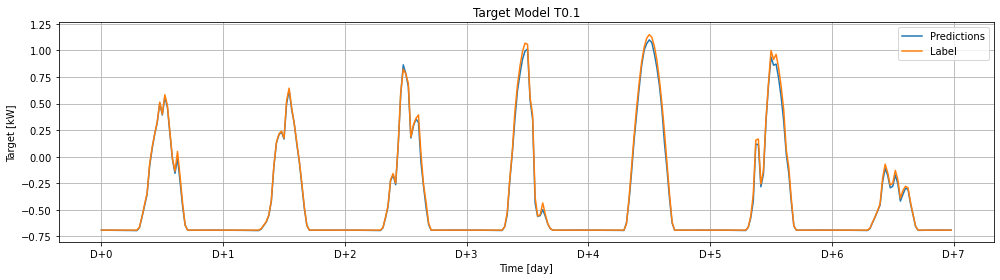

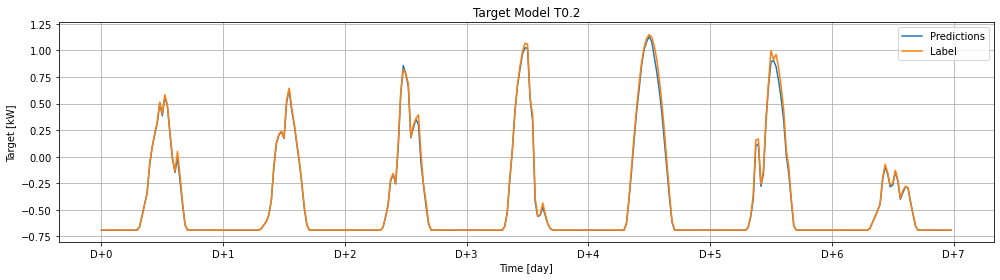

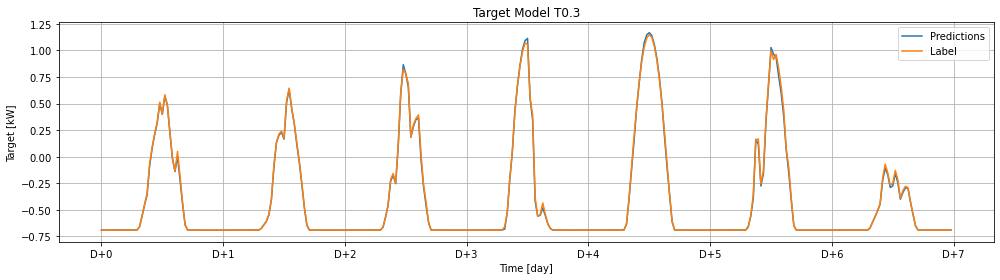

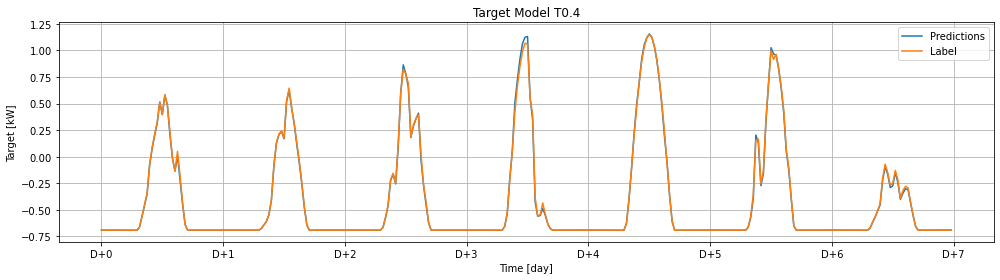

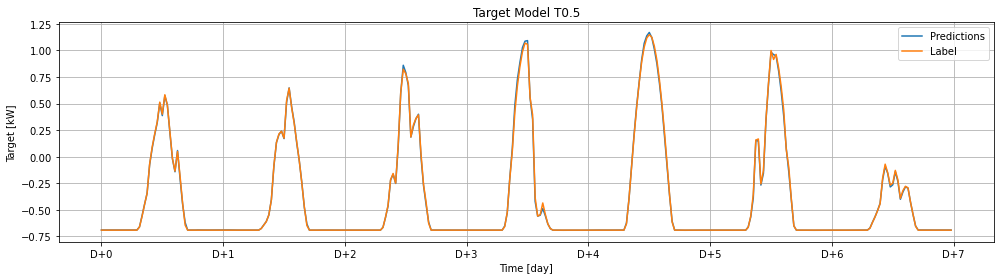

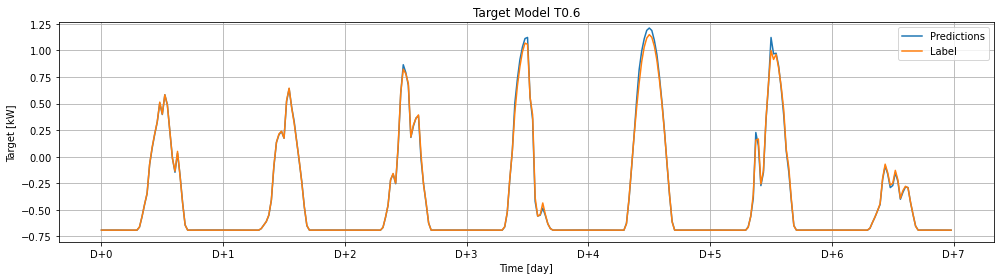

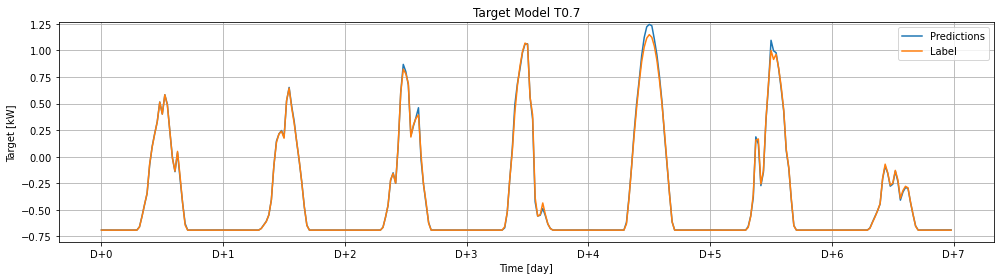

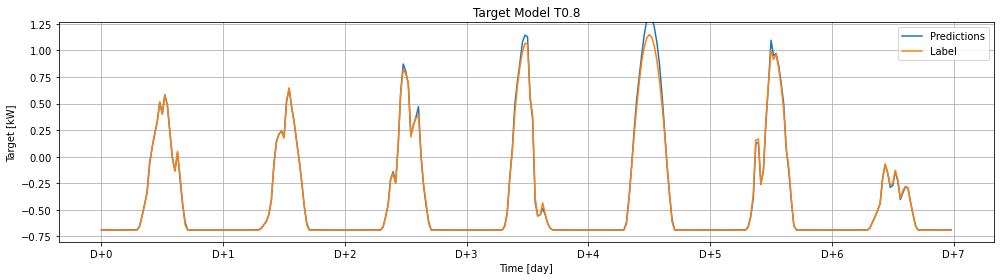

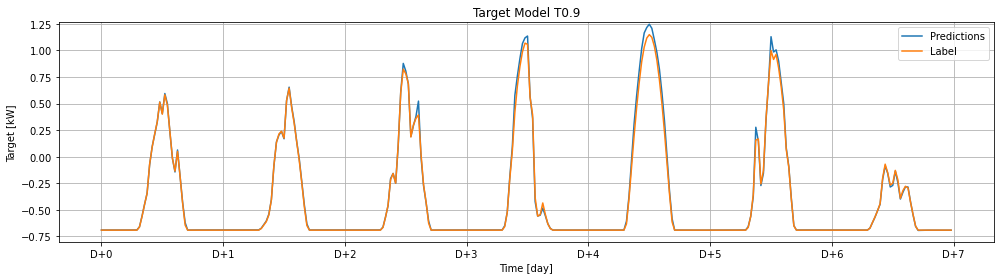

In [29]:
ts_dataset = ts_dataset.unbatch().batch(args["WINDOW_INP"])
target_models = load_latest_specific_models(
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "T*"))),
    create_model_fn = TARGET_MODEL)

for t in ts_dataset.take(1):
    x, y = t # inp, tar
    
    for target_model in target_models:
        draw_pred(y_pred = target_model.predict(x), y_true = y, model_name = target_model.name)

# **Phase \#2: Autoregressive Model**

## **Make Dataset Pipelines**

In [30]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    """inp: [batch, 336, 7], tar: (aux: [batch, 96, 7], real: [batch, 96, 1])"""
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 0)
    return inp[..., :-1], (tar[..., :-1], tar[..., -1:])


@tf.function
def _split_window_ts(features):
    """inp: [batch, 336, 7]"""
    return features[..., :-1]

In [31]:
del tr_dataset, vl_dataset, ts_dataset

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).shuffle(100_000
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
#                     ).shuffle(100_000
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
#                     ).shuffle(100_000
                    ).batch(args["NUM_TEST_CSV"] # not args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 96, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None)))
vl_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 96, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None)))
ts_dataset: TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)


### **Take Samples**

In [63]:
for element in tr_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 336, 7) (128, 96, 7) (128, 96, 1)


In [64]:
for element in vl_dataset.take(1):
    foo, (bar, qux) = element
    print(foo.shape, bar.shape, qux.shape)

(128, 336, 7) (128, 96, 7) (128, 96, 1)


In [65]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 336, 7)


## **Create Network**

In [32]:
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] => [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_rnn = tf.keras.layers.RNN([
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units)], return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        aux_outputs, real_outputs = [], []
        
        prediction, state = self.warmup(inputs)
        
        aux_outputs.append(prediction)
        real_outputs.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = tf.expand_dims(prediction, axis = 1)
            # [batch, num_features] => [batch, units]
            x, *state = self.lstm_rnn(x, initial_state = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            
            aux_outputs.append(prediction)
            real_outputs.append(self.target_model(prediction))
            
        aux_outputs = tf.stack(aux_outputs, axis = 1)
        real_outputs = tf.stack(real_outputs, axis = 1)
        return (aux_outputs, real_outputs)

## **Compile and Fit**

In [33]:
%%time

target_models = load_latest_specific_models(
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "T*"))),
    create_model_fn = TARGET_MODEL)
target_models.reverse() # to use pop()

for tau in np.arange(0.1, 1, 0.1):
    model = AR_LSTM(
        target_model = target_models.pop(),
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"],
        name = f"P{tau:.1f}")

    _ = compile_and_fit(model, tau, tr_dataset, vl_dataset, args["EPOCH"], verbose = 2, loss_weights = [1.0, 0.2])


Load latest checkpoints: ckpt/try37/T0.1/cp-434-0.0033.ckpt...
Load latest checkpoints: ckpt/try37/T0.2/cp-429-0.0045.ckpt...
Load latest checkpoints: ckpt/try37/T0.3/cp-420-0.0057.ckpt...
Load latest checkpoints: ckpt/try37/T0.4/cp-303-0.0064.ckpt...
Load latest checkpoints: ckpt/try37/T0.5/cp-258-0.0064.ckpt...
Load latest checkpoints: ckpt/try37/T0.6/cp-429-0.0065.ckpt...
Load latest checkpoints: ckpt/try37/T0.7/cp-359-0.0060.ckpt...
Load latest checkpoints: ckpt/try37/T0.8/cp-303-0.0049.ckpt...
Load latest checkpoints: ckpt/try37/T0.9/cp-469-0.0030.ckpt...
Model P0.1...
Epoch 1/10
7/7 - 164s - loss: 0.3887 - output_1_loss: 0.3559 - output_2_loss: 0.1640 - val_loss: 0.1855 - val_output_1_loss: 0.1682 - val_output_2_loss: 0.0862
Epoch 2/10
7/7 - 5s - loss: 0.1652 - output_1_loss: 0.1475 - output_2_loss: 0.0883 - val_loss: 0.1593 - val_output_1_loss: 0.1433 - val_output_2_loss: 0.0800
Epoch 3/10
7/7 - 5s - loss: 0.1532 - output_1_loss: 0.1382 - output_2_loss: 0.0750 - val_loss: 0.145

In [ ]:
# models[0].summary()

In [76]:
# %tensorboard --logdir logs/fit --host jupyter-server

## **Predict**

In [34]:
def load_latest_models():
    """Load latest weights of target model from saved ckeckpoints."""
    ckpt_folders = sorted(glob.glob(os.path.join(os.environ["CHECKPOINT_PATH"], os.environ["NOTEBOOKNAME"], "P*")))
    models = []

    for f in ckpt_folders:
        latest = tf.train.latest_checkpoint(f)
        print(f"Load latest checkpoints: {latest}...")

        # Define a new target model and load checkpoints.
        model_name = latest.split(os.path.sep)[2]
        model = AR_LSTM(
            target_model = TARGET_MODEL(model_name = f"T{model_name[1:]}"),
            units = args["NUM_UNITS"],
            out_steps = args["WINDOW_TAR"],
            name = model_name)

        ckpt = tf.train.Checkpoint(model)
        ckpt.restore(latest).expect_partial()

        models.append(model)
        
    return models

In [35]:
%%time
models = load_latest_models()
preds = [np.array(model.predict(ts_dataset)[-1])[..., 0] for model in models] # use only real outputs.

Load latest checkpoints: ckpt/try37/P0.1/cp-010-0.1361.ckpt...
Load latest checkpoints: ckpt/try37/P0.2/cp-010-0.1602.ckpt...
Load latest checkpoints: ckpt/try37/P0.3/cp-008-0.1843.ckpt...
Load latest checkpoints: ckpt/try37/P0.4/cp-010-0.1870.ckpt...
Load latest checkpoints: ckpt/try37/P0.5/cp-010-0.1990.ckpt...
Load latest checkpoints: ckpt/try37/P0.6/cp-010-0.1939.ckpt...
Load latest checkpoints: ckpt/try37/P0.7/cp-009-0.2169.ckpt...
Load latest checkpoints: ckpt/try37/P0.8/cp-009-0.1771.ckpt...
Load latest checkpoints: ckpt/try37/P0.9/cp-010-0.1260.ckpt...
CPU times: user 3min, sys: 71.5 ms, total: 3min
Wall time: 3min


In [36]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
    foo = (foo * args["TARGET_STD"]) + args["TARGET_MEAN"]
    foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [42]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.18314,0.0,0.0,0.0,0.252264,1.224497,0.943829,1.496761
0.csv_Day7_0h30m,0.0,0.00041,0.0,0.0,0.0,0.202412,1.063919,0.793205,1.479120
0.csv_Day7_1h00m,0.0,0.00000,0.0,0.0,0.0,0.139988,0.912163,0.686674,1.495377
0.csv_Day7_1h30m,0.0,0.00000,0.0,0.0,0.0,0.062437,0.783857,0.634907,1.548515
0.csv_Day7_2h00m,0.0,0.00000,0.0,0.0,0.0,0.000000,0.679262,0.641481,1.644571


In [43]:
submission.to_csv(
    os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))